### Machine learning linear regression : Food Delivery Time Prediction

In [11]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 57.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 MB 48.2 MB/s eta 0:00:0000:0100:01


In [2]:
#import required libraries
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor


In [3]:
# Download the dataset
!kaggle datasets download -d denkuznetz/food-delivery-time-prediction -p ../data
!unzip ../data/food-delivery-time-prediction.zip -d ../data

Dataset URL: https://www.kaggle.com/datasets/denkuznetz/food-delivery-time-prediction
License(s): apache-2.0
  0%|                                               | 0.00/11.6k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 11.6k/11.6k [00:00<00:00, 19.8MB/s]
Archive:  ../data/food-delivery-time-prediction.zip
  inflating: ../data/Food_Delivery_Times.csv  


### Data Preparation

In [3]:
#load the dataset
df = pd.read_csv("../data/Food_Delivery_Times.csv")

In [4]:
len(df)

1000

The dataset contains 1000 rows and 9 columns. Let's take a look at the first few rows of the dataset.

In [5]:
df.head(1)

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43


Convert column names to lowercase and remove spaces

In [6]:
# Convert column names to lowercase
df.columns = [col.lower() for col in df.columns]
df.head(1)

,order_id,distance_km,weather,traffic_level,time_of_day,vehicle_type,preparation_time_min,courier_experience_yrs,delivery_time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43


In [7]:
df.dtypes

order_id                    int64
distance_km               float64
weather                    object
traffic_level              object
time_of_day                object
vehicle_type               object
preparation_time_min        int64
courier_experience_yrs    float64
delivery_time_min           int64
dtype: object

In [8]:
# Remove order_id as it's not relevant for analysis
df = df.drop('order_id', axis=1)


In [9]:
categorical_features = ['weather','traffic_level','time_of_day','vehicle_type']
numerical_features = ['distance_km','preparation_time_min','courier_experience_yrs','delivery_time_min']

In [10]:
print(df.describe().round(2))   

       distance_km  preparation_time_min  courier_experience_yrs  \
count      1000.00               1000.00                  970.00   
mean         10.06                 16.98                    4.58   
std           5.70                  7.20                    2.91   
min           0.59                  5.00                    0.00   
25%           5.11                 11.00                    2.00   
50%          10.19                 17.00                    5.00   
75%          15.02                 23.00                    7.00   
max          19.99                 29.00                    9.00   

       delivery_time_min  
count            1000.00  
mean               56.73  
std                22.07  
min                 8.00  
25%                41.00  
50%                55.50  
75%                71.00  
max               153.00  


### EDA - Exploratory Data Analysis

Let's examine the unique values in each categorical feature to better understand our dataset. This will help us identify potential data quality issues and understand the distribution of categories.

In [11]:
print("Unique values in each categorical feature:")
for col in categorical_features:
    print(f"{col}: {df[col].unique()}")

Unique values in each categorical feature:
weather: ['Windy' 'Clear' 'Foggy' 'Rainy' 'Snowy' nan]
traffic_level: ['Low' 'Medium' 'High' nan]
time_of_day: ['Afternoon' 'Evening' 'Night' 'Morning' nan]
vehicle_type: ['Scooter' 'Bike' 'Car']


Now, lets check for missing values in the dataset and address them.

In [12]:
df.isnull().sum()

distance_km                0
weather                   30
traffic_level             30
time_of_day               30
vehicle_type               0
preparation_time_min       0
courier_experience_yrs    30
delivery_time_min          0
dtype: int64

Handling Missing Values
For this dataset:
- Weather conditions, traffic level, and time of day are likely random missing values
- Courier experience could indicate new hires when missing

Recommended approach:
- Use mode imputation for categorical variables as they represent common conditions
- Use median for courier_experience_yrs as it's less sensitive to outliers than mean

In [13]:
# Fill missing missing values values with mode (most frequent value)
df['weather'] = df['weather'].fillna(df['weather'].mode()[0])
df['traffic_level'] = df['traffic_level'].fillna(df['traffic_level'].mode()[0])
df['time_of_day'] = df['time_of_day'].fillna(df['time_of_day'].mode()[0])

# Fill missing missing values values with median (middle value)
df['courier_experience_yrs'] = df['courier_experience_yrs'].fillna(df['courier_experience_yrs'].median())

In [14]:
df.isnull().sum()

distance_km               0
weather                   0
traffic_level             0
time_of_day               0
vehicle_type              0
preparation_time_min      0
courier_experience_yrs    0
delivery_time_min         0
dtype: int64

In [15]:
df['delivery_time_min'].value_counts()

delivery_time_min
71     23
44     22
48     22
43     21
51     21
       ..
103     1
99      1
126     1
122     1
114     1
Name: count, Length: 108, dtype: int64

There is 108 different delivery times in the dataset. The most frequent is 71 minutes for a delivery. Let's check the distribution of delivery times.

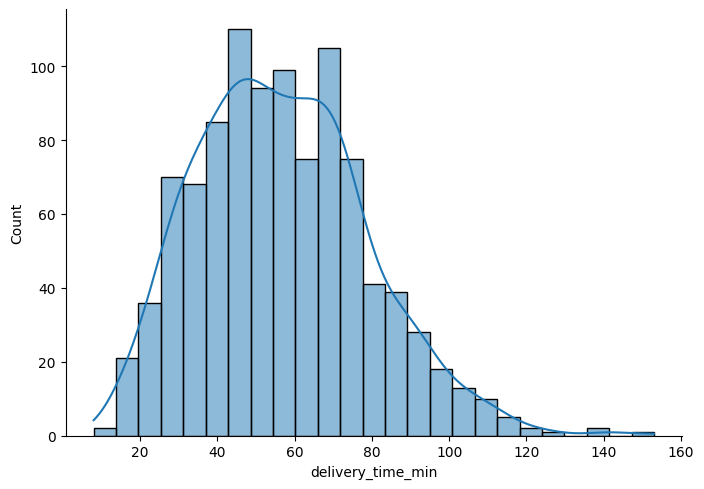

In [16]:
sns.displot(x='delivery_time_min',data=df,aspect=10/7,kde=True)

**Distribution Shape**

The histogram appears to be unimodal (single peak) and positively skewed (tail extending to the right). This indicates that most delivery times fall within a certain range, but there are less frequent instances of much longer delivery times pulling the distribution's tail to the right.

**Central Tendency**

**Mode:** The modal class (most frequent bin) seems to be in the 60-70 minute range. This suggests the most common delivery times fall within this interval.

**Median:** Since the distribution is skewed, the median (middle value) is likely to be slightly higher than the mode. It probably lies somewhere in the 70-80 minute range because the tail is pulling the mean and median towards the higher values.

**Mean:** The mean (average) will be the most affected by the long tail and is expected to be greater than the median and mode. It's likely located somewhere above 80 minutes.


**Spread/Variability**

**Range:** The data spans from around 20 minutes to a little over 160 minutes, giving a wide range. 

**Interquartile Range (IQR):** Due to the skewness, IQR would be a more appropriate measure of spread than the standard deviation. It's difficult to estimate visually but would likely capture the spread of the central 50% of the data, offering a better representation of the variability of typical delivery times.

**Outliers:** The data points in the far right tail (beyond 120 minutes, for example) could be considered potential outliers. These warrant further investigation to understand if they represent genuine extreme delivery times or if they are due to errors in data collection or specific circumstances (e.g., traffic, weather).

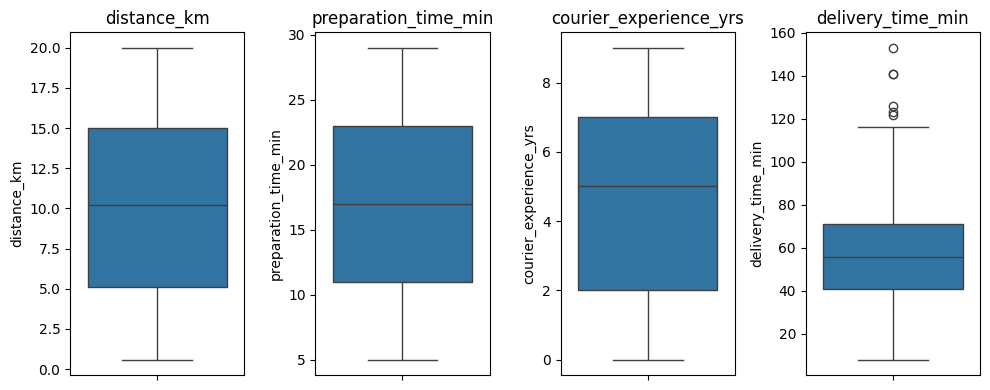

In [29]:
plt.figure(figsize=(10, 4))

for i, col in enumerate(numerical_features):
    plt.subplot(1, len(numerical_features), i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

1. distance_km (Distance in Kilometers):
* Median: The median distance appears to be around 12-13 km. This represents the typical distance for the deliveries in the dataset.
* Interquartile Range (IQR): The IQR (the box's height) spans roughly from 7 km to 17 km. This indicates that the middle 50% of deliveries fall within this distance range. This is a substantial spread, suggesting considerable variability in delivery distances.
* Range: The full range of distances extends from nearly 0 km to about 20 km.
* Potential Outliers: There are no apparent outliers on the lower end. However, the maximum distance of 20 km could be considered a potential outlier, depending on the context. It's significantly higher than the rest of the data.
2. preparation_time_min (Preparation Time in Minutes):
* Median: The median preparation time is approximately 15 minutes.
* IQR: The IQR ranges from about 10 minutes to 20 minutes. This indicates a moderate amount of variability in preparation times.
* Range: The data spans from roughly 5 minutes to 30 minutes.
* Potential Outliers: The maximum value of 30 minutes could be considered a potential outlier. It's notably higher than the rest of the distribution.
3. courier_experience_yrs (Courier Experience in Years):
* Median: The median courier experience is around 5 years.
* IQR: The IQR extends from approximately 2 to 8 years. This shows a reasonable range of experience levels among the couriers.
* Range: The experience ranges from 0 years (presumably new couriers) to about 8 years.
* Potential Outliers: There are no clear outliers in this variable.
4. delivery_time_min (Delivery Time in Minutes):
* Median: The median delivery time is roughly 60 minutes.
* IQR: The IQR ranges from about 40 minutes to 80 minutes. This demonstrates significant variability in delivery times.
* Range: The data spans from approximately 20 minutes to 160 minutes.
* Potential Outliers: There are several potential outliers on the higher end, above 100 minutes. These extreme values suggest that some deliveries experienced substantial delays.

/tmp/ipykernel_1868/4042389426.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df,x='courier_experience_yrs',y='delivery_time_min',palette='plasma')


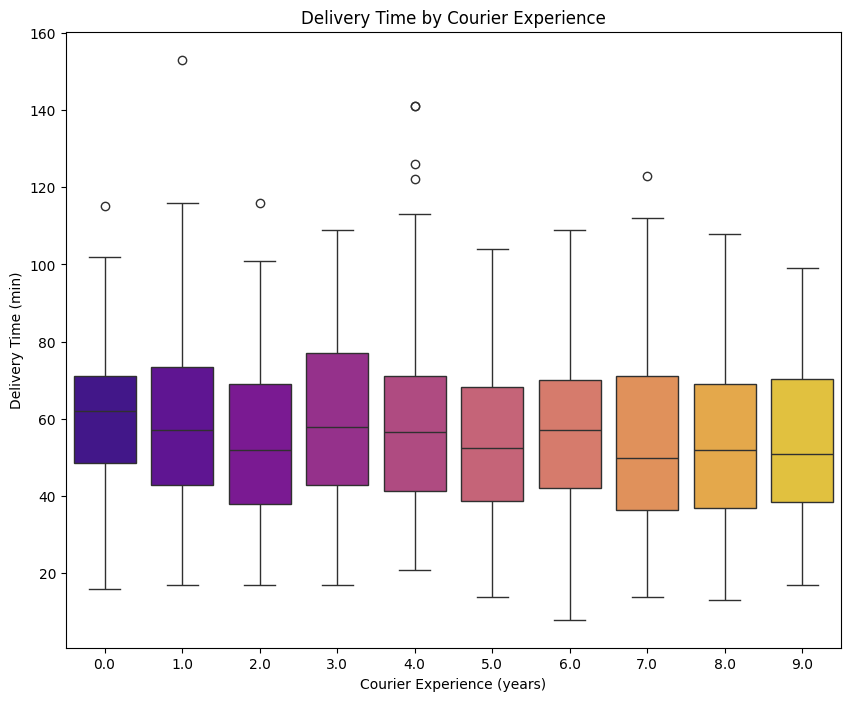

In [20]:
plt.figure(figsize=(10,8))
sns.boxplot(data=df,x='courier_experience_yrs',y='delivery_time_min',palette='plasma')
plt.title("Delivery Time by Courier Experience")
plt.xlabel("Courier Experience (years)")
plt.ylabel("Delivery Time (min)")
plt.show()